# Chest X-ray Images

The purpose of this project is to build a machine learning model to detect pneumonia (specifically bacterial or viral pneumonia) from chest X-ray images. The model aims to automatically classify X-ray images as either "normal" or showing signs of pneumonia, which could help doctors quickly identify potential pneumonia cases in patients and improve diagnosis efficiency.

#### Dataset

- **Source**: Labeled Chest X-Ray Images Dataset.
- **Total images**: 5,856 validated chest X-rays.
- **Categories**: Normal, Bacterial Pneumonia, Viral Pneumonia.
- **Split**: Training and testing sets based on independent patients.

### 1. Import Libraries

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

### 2. Load and Prepare the Dataset

In [2]:
zip_path = 'Disease Detection.zip'
extraction_path = 'Disease_Detection'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Function to load and preprocess images
def load_images_from_folder(folder, img_size=(128, 128)):
    images, labels = [], []
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            for label in os.listdir(category_path):
                label_folder = os.path.join(category_path, label)
                if os.path.isdir(label_folder):
                    for filename in os.listdir(label_folder):
                        img_path = os.path.join(label_folder, filename)
                        try:
                            img = Image.open(img_path).convert('RGB')  # Convert to RGB
                            img = img.resize(img_size)  # Resize the image
                            images.append(np.array(img))
                            labels.append(label)  # Append the label
                        except Exception as e:
                            print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load images
images, labels = load_images_from_folder(extraction_path)

# Normalize pixel values
images = images.astype('float32') / 255.0

# One-hot encode the labels (ensure two columns for two classes)
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)

# Check if the encoding needs adjustment (e.g., in case of binary classification)
if labels_encoded.shape[1] == 1:  # If only one column, convert to two columns
    labels_encoded = np.hstack((1 - labels_encoded, labels_encoded))  # Invert binary labels to get two columns

# Now you can proceed to split the data and train the model
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.30, random_state=42, stratify=labels_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

### 3. Data Augmentation

The code applies data augmentation to increase the diversity of the training data, which helps improve the model's ability to generalize.

The model will see slightly modified versions of the same image during training, such as rotated, shifted, or zoomed images. This makes the model more robust to different orientations and variations in the images.

In [3]:
# Define the Data Augmentation Generator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
train_datagen.fit(X_train)

### 4. Convolutional Neural Network (CNN) Architecture

The CNN architecture is built to classify images by detecting patterns (like edges, textures, and more complex features) at different levels of abstraction.

In [ ]:
# Build the CNN Model

model = Sequential()

# Input layer
model.add(Input(shape=(128, 128, 3)))

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization

# Output Layer (Assuming 2 classes: 'normal' and 'opacity')
model.add(Dense(2, activation='softmax'))  # Multi-class classification

### 5. Model Compilation and Training

The model is trained to minimize classification errors using the training data and adjusted using the validation set to avoid overfitting.

In [4]:
# Compile the Model

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Confirm the model structure
model.summary()

# Train the Model

batch_size = 16  # Adjust batch size for your system's memory
# Now train the model with properly encoded labels
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=50,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size
)

# Optionally, save the model after training
# model.save('pneumonia_detection_model.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\milto\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 210ms/step - accuracy: 0.6952 - loss: 0.6594 - val_accuracy: 0.7301 - val_loss: 0.5465
Epoch 2/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.6875 - loss: 0.6415

C:\Users\milto\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6875 - loss: 0.6415 - val_accuracy: 0.7301 - val_loss: 0.5439
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 199ms/step - accuracy: 0.7381 - loss: 0.5216 - val_accuracy: 0.7449 - val_loss: 0.5746
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8750 - loss: 0.5213 - val_accuracy: 0.7483 - val_loss: 0.5395
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 204ms/step - accuracy: 0.7667 - loss: 0.4726 - val_accuracy: 0.7870 - val_loss: 0.4654
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8125 - loss: 0.3610 - val_accuracy: 0.7768 - val_loss: 0.4637
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.8005 - loss: 0.4086 - val_accuracy: 0.8075 - val_loss: 0.3611
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8125 - loss: 0.3882 - val_accuracy: 0.8041 - val_loss: 0.3604
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 49s 191ms/step - accuracy: 0.8383 - loss: 0.3435 - val_accuracy: 

### Interpretation

- **Overfitting Concerns**: The training accuracy increased to 100% by the last epoch, while the validation accuracy decreased slightly, suggesting the model may be overfitting the training data. This means the model is performing very well on the training set but may not generalize as well on unseen data.
- **Model Performance**: Overall, the model shows high performance with over 90% accuracy on both training and validation sets. However, it's essential to monitor for overfitting, especially as the training accuracy hits 100%.

### 6. Evaluating the Model's Performance

After training, the model is tested on a separate test set to measure its performance and check how well it generalizes to new, unseen images.

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.78      0.95      0.85       238
     opacity       0.98      0.90      0.94       641

    accuracy                           0.91       879
   macro avg       0.88      0.92      0.90       879
weighted avg       0.92      0.91      0.91       879



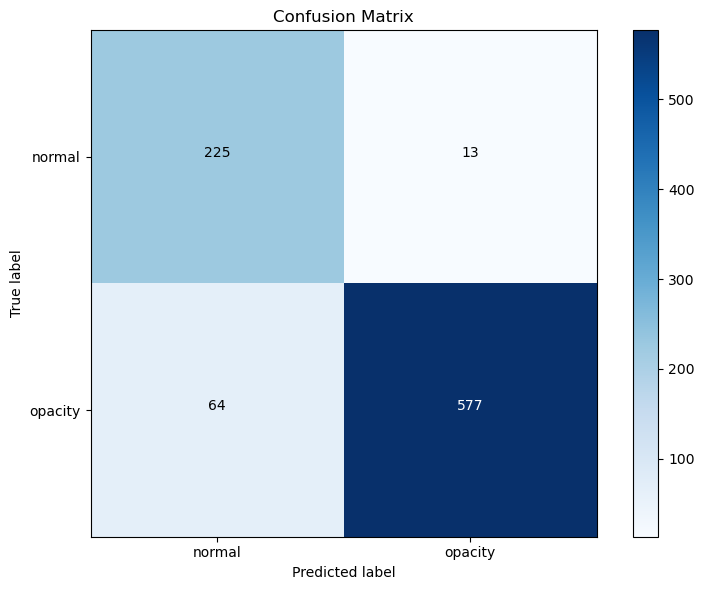

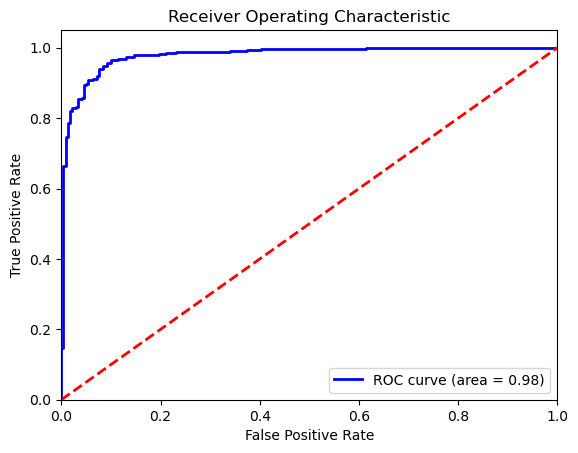

In [5]:
# Predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=lb.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_)
plt.yticks(tick_marks, lb.classes_)

# Display Confusion Matrix values
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f'{conf_matrix[i, j]}', horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])  # Probabilities of the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Interpretation

- **High Precision for "opacity"**: The model is particularly good at correctly identifying "opacity" cases when it predicts them (high precision for "opacity" at 0.98).
- **High Recall for "normal"**: The model is very good at identifying "normal" cases (95% recall for "normal").
- **Imbalance in Classes**: There are more "opacity" cases than "normal," which could be why the "opacity" class shows higher precision and recall scores than the "normal" class.
- **Strong Overall Performance**: The weighted average F1-score of 0.91 and accuracy of 0.91 indicate strong overall performance, with the model generalizing well on both classes.

### 7. Predicting on a New Image

After training, you can use the model to predict the class of a new chest X-ray image.

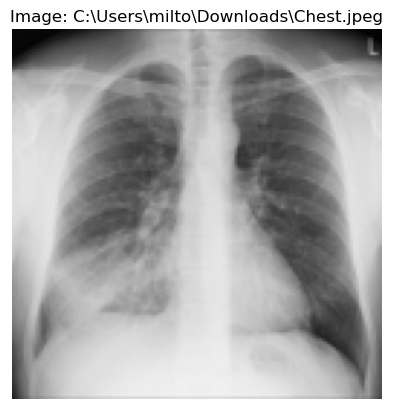

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label for C:\Users\milto\Downloads\Chest.jpeg: normal


In [6]:
# Load and Predict on a New Image

# Function to load, preprocess, and visualize the image
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    try:
        img = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
        img_resized = img.resize(img_size)  # Resize to match model input
        img_array = np.array(img_resized).astype('float32') / 255.0  # Normalize pixel values
        
        # Display the image to check
        plt.imshow(img_resized)
        plt.title(f"Image: {image_path}")
        plt.axis('off')  # Hide axes for clarity
        plt.show()

        return np.expand_dims(img_array, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load New Image and Predict
image_path = 'C:\\Users\\milto\\Downloads\\Chest.jpeg'
new_image = load_and_preprocess_image(image_path)

if new_image is not None:
    predictions = model.predict(new_image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    label_map = {0: 'normal', 1: 'opacity'}  
    predicted_label = label_map[predicted_class]
    print(f'Predicted Label for {image_path}: {predicted_label}')


**The model predicts the image is a "normal" condition.**

## Conclusion

After preprocessing the data and building a convolutional neural network (CNN) model, we achieved a solid performance with an overall accuracy of 91%. The model demonstrated particularly strong precision for the "opacity" class (0.98) and high recall for the "normal" class (0.95), suggesting that it is highly effective at identifying both conditions in the dataset.

The performance metrics, including the F1-scores (0.85 for "normal" and 0.94 for "opacity"), indicate that the model balances precision and recall effectively, although slight improvements could still be made, especially for the "opacity" class to increase recall further. Additionally, the class imbalance in the dataset, with more instances of "opacity," may have contributed to the better performance for that class.

Overall, the model achieved strong predictive performance, making it a viable solution for predicting these conditions. Future work could focus on further fine-tuning the model, experimenting with different architectures, or exploring methods to address class imbalance for even better generalization across both classes.